# Intermediate Process Analysis: Regret and Convergence Curves
## Intermediate Process Data Analysis: Regret Values and Convergence Curves

This notebook analyzes the intermediate process data collected from `run_experiments_parallel.py` results, including:
- **Instantaneous Regret**: `true_optimal - current_step_value`
- **Simple Regret**: `true_optimal - best_so_far`
- **Cumulative Regret**: `sum(instantaneous_regrets)`
- **X_GAP**: Distance from true optimal input
- **Y_GAP**: Distance from true optimal output

**Key Analysis Questions**:
1. How do CBO and BO converge over iterations?
2. Which algorithm achieves lower regret faster?
3. What are the convergence patterns across different graph types?
4. How consistent are the optimization trajectories across random seeds?


## Setup and Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

print("📊 Environment setup complete!")
print("🔬 Analysis tools loaded: pandas, matplotlib, seaborn, scipy")
print("📈 Ready for intermediate process analysis!")

📊 Environment setup complete!
🔬 Analysis tools loaded: pandas, matplotlib, seaborn, scipy
📈 Ready for intermediate process analysis!


## Load Experimental Results

In [10]:
# Find the latest results file
results_files = glob.glob('results/parallel_results_100_20250723_000400.json')
if not results_files:
    print("❌ No results files found!")
    print("💡 Please run: python run_experiments_parallel.py")
    results = None
else:
    # Use the most recent file
    latest_file = max(results_files, key=os.path.getctime)
    print(f"📁 Loading results from: {latest_file}")
    
    try:
        with open(latest_file, 'r', encoding='utf-8') as f:
            results = json.load(f)
        
        print("✅ Successfully loaded experimental results!")
        print(f"📊 Experiment configuration:")
        print(f"   • Algorithms: {', '.join(results['experiment_config']['algorithms'])}")
        print(f"   • Benchmarks: {', '.join(results['experiment_config']['graph_types'])}")
        print(f"   • Seeds per experiment: {len(results['experiment_config']['seeds'])}")
        print(f"   • Iterations per run: {results['experiment_config']['num_trials']}")
        print(f"   • Total experiments: {len(results['detailed_results'])}")
        print(f"   • Success rate: {results['experiment_config']['success_rate']:.1%}")
        
        # Check if intermediate data is available
        has_intermediate = any('intermediate_data' in r for r in results['detailed_results'])
        if has_intermediate:
            print("✅ Intermediate process data found!")
        else:
            print("⚠️ No intermediate process data found in results")
            print("💡 Make sure you're using the updated BO_botorch.py and CBO_botorch.py files")
        
    except Exception as e:
        print(f"❌ Error loading results: {e}")
        results = None

📁 Loading results from: results/parallel_results_100_20250723_000400.json
✅ Successfully loaded experimental results!
📊 Experiment configuration:
   • Algorithms: BO, CBO
   • Benchmarks: ToyGraph, CompleteGraph, CoralGraph, SimplifiedCoralGraph
   • Seeds per experiment: 3
   • Iterations per run: 50
   • Total experiments: 24
   • Success rate: 100.0%
✅ Intermediate process data found!


## Extract and Structure Intermediate Data

In [11]:
if results and any('intermediate_data' in r for r in results['detailed_results']):
    # Extract intermediate data from detailed results
    intermediate_data = {}
    
    for result in results['detailed_results']:
        if result['success'] and 'intermediate_data' in result:
            key = f"{result['algorithm']}_{result['graph_type']}_seed{result['seed']}"
            intermediate_data[key] = {
                'algorithm': result['algorithm'],
                'graph_type': result['graph_type'],
                'seed': result['seed'],
                'gpu_id': result.get('gpu_id'),
                'final_value': result.get('final_value'),
                'runtime': result.get('runtime'),
                'wall_time': result.get('wall_time'),
                **result['intermediate_data']  # Unpack intermediate data
            }
    
    print(f"📊 Extracted intermediate data from {len(intermediate_data)} successful experiments")
    
    # Show data structure
    if intermediate_data:
        sample_key = list(intermediate_data.keys())[0]
        sample_data = intermediate_data[sample_key]
        
        print(f"\n🔍 Sample data structure (from {sample_key}):")
        for key, value in sample_data.items():
            if isinstance(value, list):
                print(f"   • {key}: {len(value)} data points")
                if value:  # Show first few values if available
                    preview = value[:3] if len(value) > 3 else value
                    print(f"     Preview: {preview}...")
            else:
                print(f"   • {key}: {value}")
        
        # Count data availability by algorithm and graph type
        data_summary = {}
        for key, data in intermediate_data.items():
            alg_graph = f"{data['algorithm']}_{data['graph_type']}"
            if alg_graph not in data_summary:
                data_summary[alg_graph] = {
                    'count': 0,
                    'regret_points': []
                }
            data_summary[alg_graph]['count'] += 1
            if data.get('simple_regrets'):
                data_summary[alg_graph]['regret_points'].append(len(data['simple_regrets']))
        
        print(f"\n📈 Data summary by algorithm and graph type:")
        for key, summary in data_summary.items():
            avg_points = np.mean(summary['regret_points']) if summary['regret_points'] else 0
            print(f"   • {key}: {summary['count']} runs, avg {avg_points:.1f} regret points per run")
            
else:
    print("❌ No intermediate data available for analysis")
    print("💡 Please ensure you're using the updated experiment scripts")
    intermediate_data = {}

📊 Extracted intermediate data from 24 successful experiments

🔍 Sample data structure (from BO_ToyGraph_seed0):
   • algorithm: BO
   • graph_type: ToyGraph
   • seed: 0
   • gpu_id: 0
   • final_value: -0.615781
   • runtime: 34.81
   • wall_time: 41.88215708732605
   • instantaneous_regrets: 50 data points
     Preview: [0.0, 0.0, 0.0]...
   • simple_regrets: 50 data points
     Preview: [0.0, 0.0, 0.0]...
   • cumulative_regrets: 50 data points
     Preview: [0.0, 0.0, 0.0]...
   • x_gaps: 0 data points
   • y_gaps: 0 data points

📈 Data summary by algorithm and graph type:
   • BO_ToyGraph: 3 runs, avg 50.0 regret points per run
   • BO_CompleteGraph: 3 runs, avg 50.0 regret points per run
   • BO_CoralGraph: 3 runs, avg 50.0 regret points per run
   • BO_SimplifiedCoralGraph: 3 runs, avg 50.0 regret points per run
   • CBO_ToyGraph: 3 runs, avg 48.0 regret points per run
   • CBO_CompleteGraph: 3 runs, avg 49.0 regret points per run
   • CBO_CoralGraph: 3 runs, avg 48.0 regret poi

## Plot 1: Simple Regret Convergence Curves

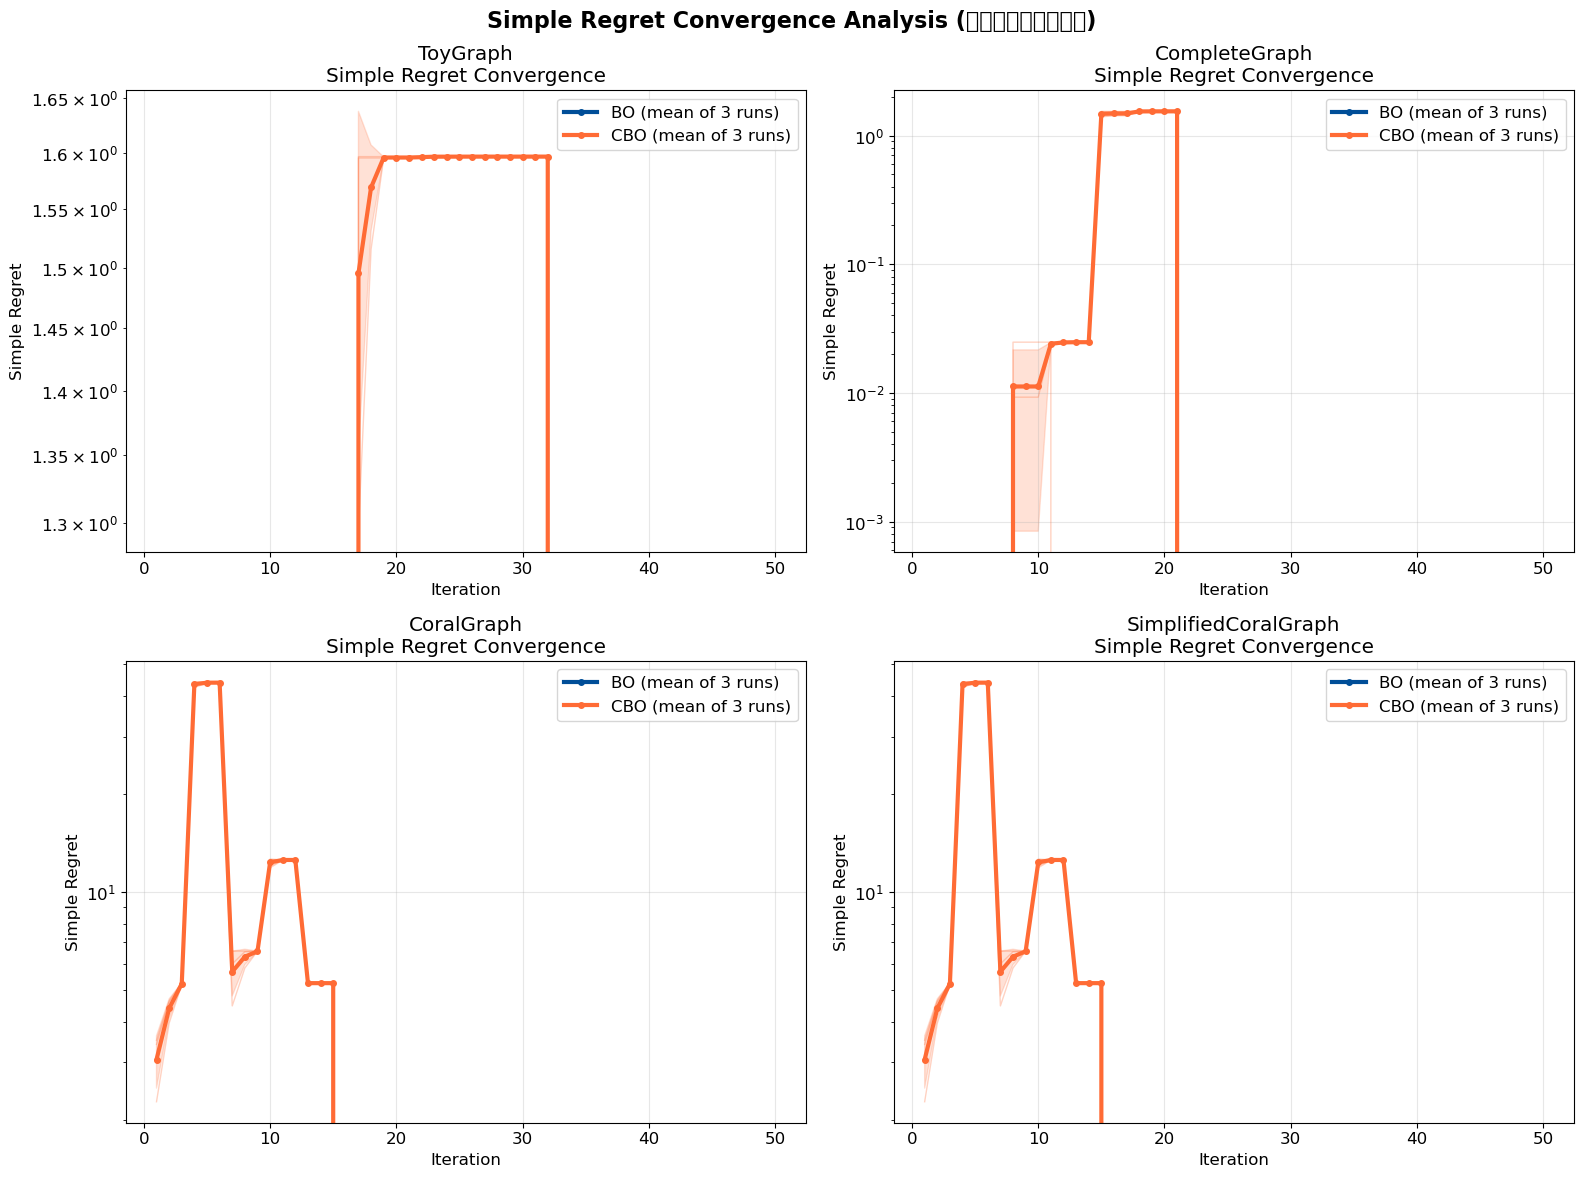

In [ ]:
if intermediate_data:
    algorithms = results['experiment_config']['algorithms']
    graph_types = results['experiment_config']['graph_types']
    colors = {'BO': '#004E98', 'CBO': '#FF6B35'}
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle('Simple Regret Convergence Analysis', fontsize=16, fontweight='bold')
    
    for i, graph_type in enumerate(graph_types[:4]):  # Limit to 4 graphs
        ax = axes[i]
        
        for algorithm in algorithms:
            # Collect all simple regret curves for this algorithm and graph type
            all_curves = []
            
            for key, data in intermediate_data.items():
                if data['algorithm'] == algorithm and data['graph_type'] == graph_type:
                    if data.get('simple_regrets') and len(data['simple_regrets']) > 0:
                        all_curves.append(data['simple_regrets'])
            
            if all_curves:
                # Plot individual curves (light)
                for curve in all_curves:
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], alpha=0.3, linewidth=1)
                
                # Calculate and plot mean curve (bold)
                if len(all_curves) > 1:
                    min_length = min(len(curve) for curve in all_curves)
                    truncated_curves = [curve[:min_length] for curve in all_curves]
                    mean_curve = np.mean(truncated_curves, axis=0)
                    std_curve = np.std(truncated_curves, axis=0)
                    
                    iterations = range(1, len(mean_curve) + 1)
                    
                    # Plot mean line
                    ax.plot(iterations, mean_curve, color=colors[algorithm], linewidth=3, 
                           label=f'{algorithm} (mean of {len(all_curves)} runs)', marker='o', markersize=4)
                    
                    # Plot confidence band
                    ax.fill_between(iterations, 
                                   np.maximum(0, mean_curve - std_curve), 
                                   mean_curve + std_curve,
                                   color=colors[algorithm], alpha=0.2)
                else:
                    # Single curve
                    curve = all_curves[0]
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], linewidth=3, 
                           label=f'{algorithm} (1 run)', marker='o', markersize=4)
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Simple Regret')
        ax.set_title(f'{graph_type}\nSimple Regret Convergence')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')  # Log scale for better visualization
    
    # Hide unused subplots
    for j in range(len(graph_types), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('results/simple_regret_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ No data available for plotting simple regret curves")

## Plot 2: Cumulative Regret Analysis

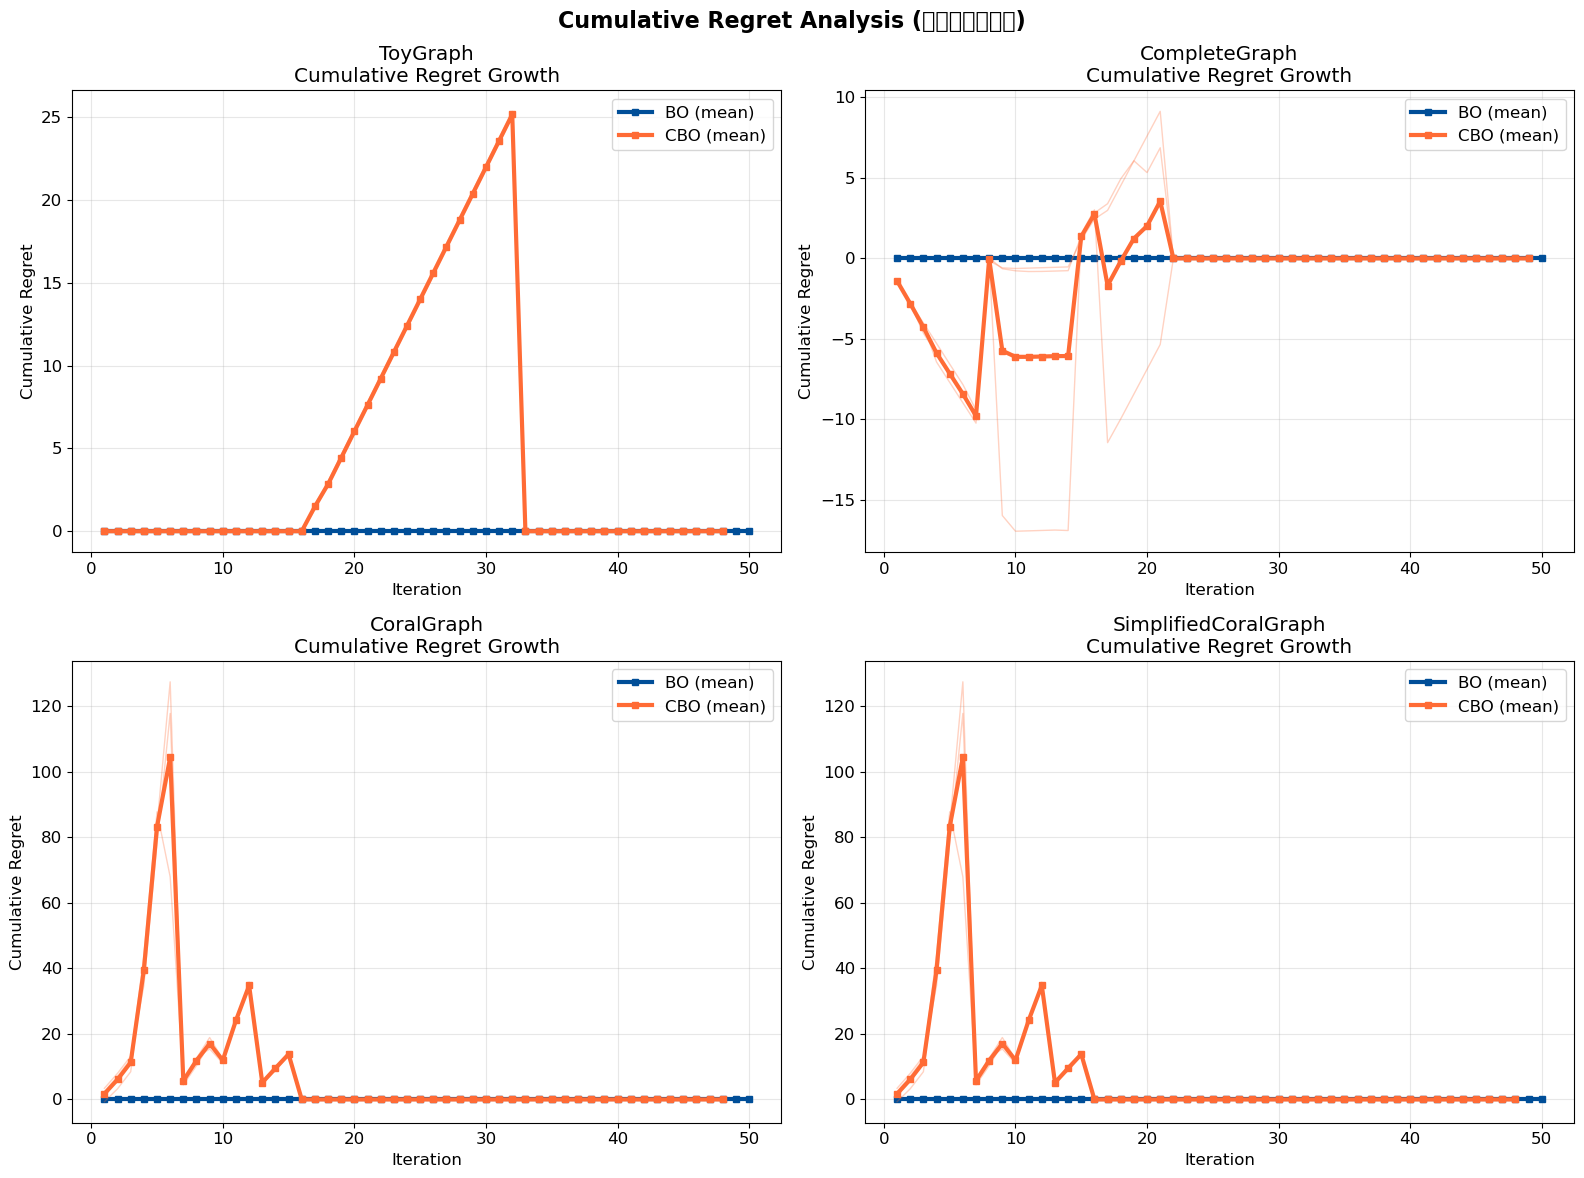

In [ ]:
if intermediate_data:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle('Cumulative Regret Analysis', fontsize=16, fontweight='bold')
    
    for i, graph_type in enumerate(graph_types[:4]):
        ax = axes[i]
        
        for algorithm in algorithms:
            # Collect cumulative regret curves
            all_curves = []
            
            for key, data in intermediate_data.items():
                if data['algorithm'] == algorithm and data['graph_type'] == graph_type:
                    if data.get('cumulative_regrets') and len(data['cumulative_regrets']) > 0:
                        all_curves.append(data['cumulative_regrets'])
            
            if all_curves:
                # Plot individual curves (light)
                for curve in all_curves:
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], alpha=0.3, linewidth=1)
                
                # Calculate and plot mean curve
                if len(all_curves) > 1:
                    min_length = min(len(curve) for curve in all_curves)
                    truncated_curves = [curve[:min_length] for curve in all_curves]
                    mean_curve = np.mean(truncated_curves, axis=0)
                    
                    iterations = range(1, len(mean_curve) + 1)
                    ax.plot(iterations, mean_curve, color=colors[algorithm], linewidth=3, 
                           label=f'{algorithm} (mean)', marker='s', markersize=4)
                else:
                    curve = all_curves[0]
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], linewidth=3, 
                           label=algorithm, marker='s', markersize=4)
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cumulative Regret')
        ax.set_title(f'{graph_type}\nCumulative Regret Growth')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(len(graph_types), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('results/cumulative_regret_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ No data available for plotting cumulative regret curves")

## Plot 3: Instantaneous Regret Evolution

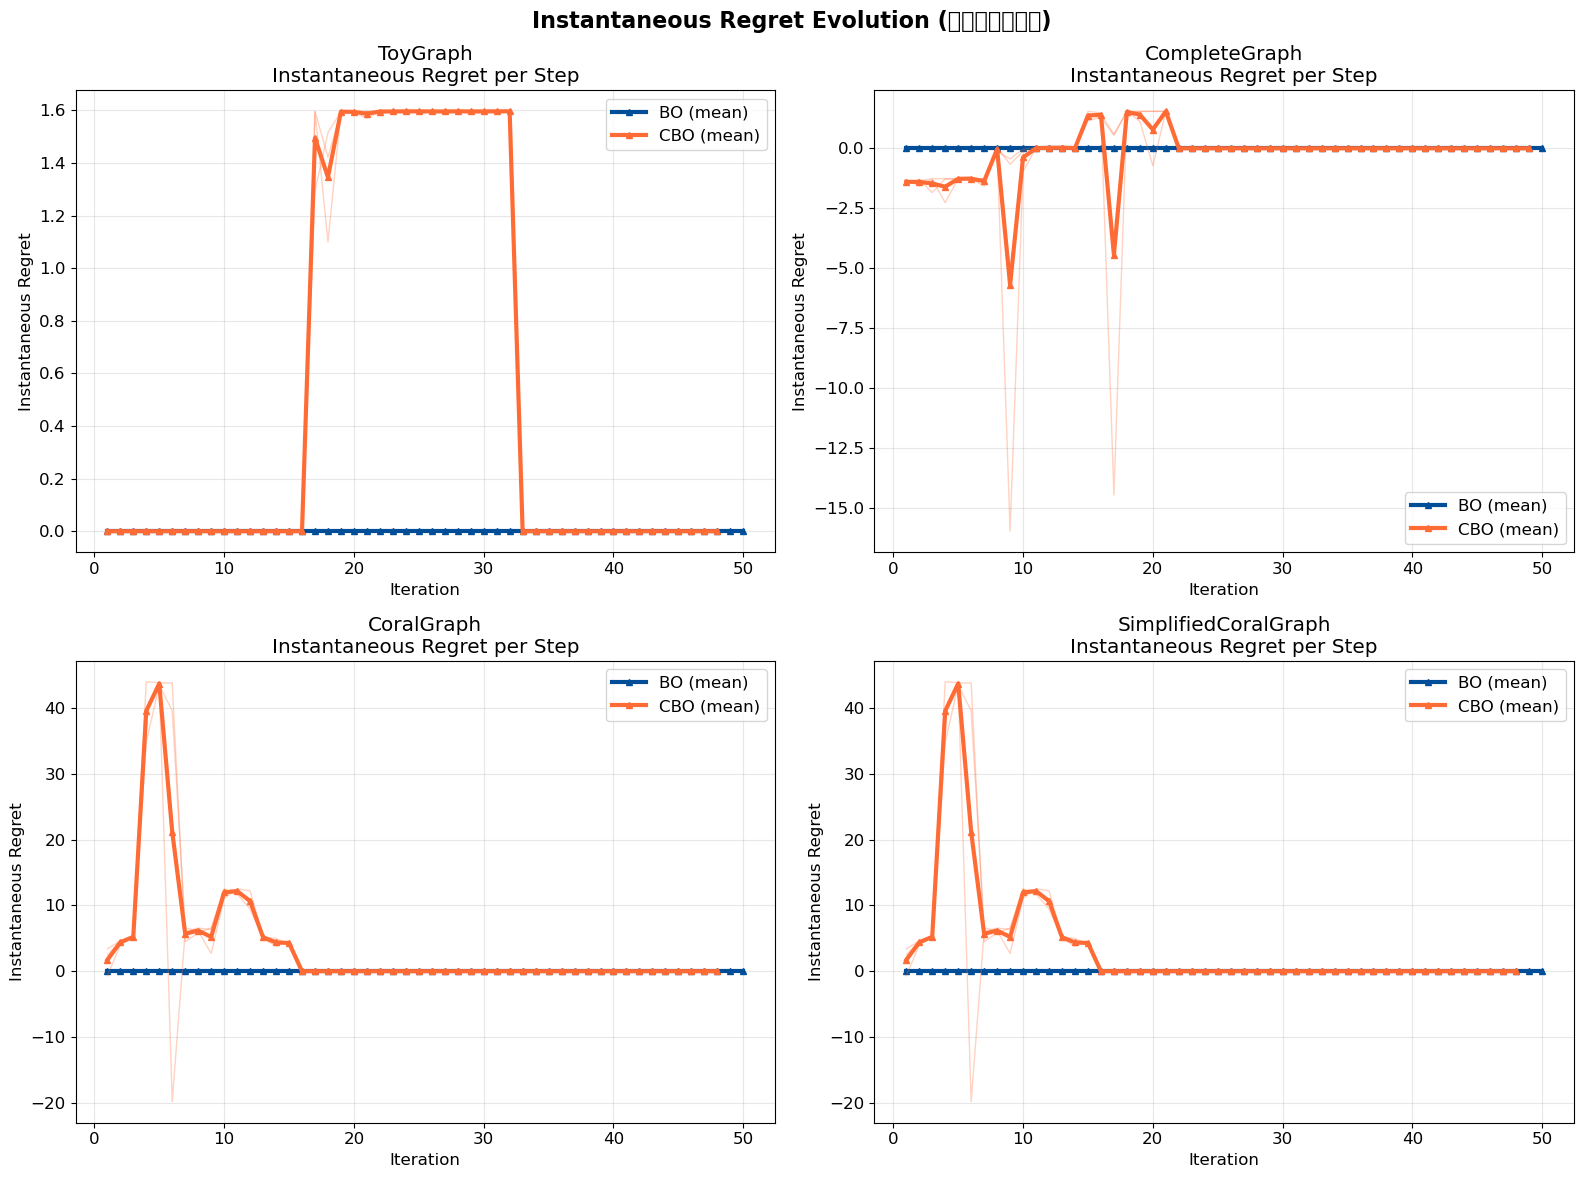

In [ ]:
if intermediate_data:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle('Instantaneous Regret Evolution', fontsize=16, fontweight='bold')
    
    for i, graph_type in enumerate(graph_types[:4]):
        ax = axes[i]
        
        for algorithm in algorithms:
            # Collect instantaneous regret curves
            all_curves = []
            
            for key, data in intermediate_data.items():
                if data['algorithm'] == algorithm and data['graph_type'] == graph_type:
                    if data.get('instantaneous_regrets') and len(data['instantaneous_regrets']) > 0:
                        all_curves.append(data['instantaneous_regrets'])
            
            if all_curves:
                # Plot individual curves (light)
                for curve in all_curves:
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], alpha=0.3, linewidth=1)
                
                # Calculate and plot mean curve
                if len(all_curves) > 1:
                    min_length = min(len(curve) for curve in all_curves)
                    truncated_curves = [curve[:min_length] for curve in all_curves]
                    mean_curve = np.mean(truncated_curves, axis=0)
                    
                    iterations = range(1, len(mean_curve) + 1)
                    ax.plot(iterations, mean_curve, color=colors[algorithm], linewidth=3, 
                           label=f'{algorithm} (mean)', marker='^', markersize=4)
                else:
                    curve = all_curves[0]
                    iterations = range(1, len(curve) + 1)
                    ax.plot(iterations, curve, color=colors[algorithm], linewidth=3, 
                           label=algorithm, marker='^', markersize=4)
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Instantaneous Regret')
        ax.set_title(f'{graph_type}\nInstantaneous Regret per Step')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(len(graph_types), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('results/instantaneous_regret_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ No data available for plotting instantaneous regret curves")

## Quantitative Convergence Analysis

In [15]:
if intermediate_data:
    print("📊 QUANTITATIVE CONVERGENCE ANALYSIS")
    print("=" * 60)
    
    convergence_stats = {}
    
    for graph_type in graph_types:
        print(f"\n🔍 {graph_type} Analysis:")
        convergence_stats[graph_type] = {}
        
        for algorithm in algorithms:
            # Collect final regrets and convergence metrics
            final_simple_regrets = []
            final_cumulative_regrets = []
            convergence_speeds = []  # Iterations to reach 90% of final performance
            
            for key, data in intermediate_data.items():
                if data['algorithm'] == algorithm and data['graph_type'] == graph_type:
                    if data.get('simple_regrets'):
                        simple_regrets = data['simple_regrets']
                        if simple_regrets:
                            final_simple_regrets.append(simple_regrets[-1])
                            
                            # Calculate convergence speed (90% of final improvement)
                            if len(simple_regrets) > 5:
                                initial_regret = simple_regrets[0] if simple_regrets[0] > 0 else max(simple_regrets)
                                final_regret = simple_regrets[-1]
                                target_regret = initial_regret - 0.9 * (initial_regret - final_regret)
                                
                                for j, regret in enumerate(simple_regrets):
                                    if regret <= target_regret:
                                        convergence_speeds.append(j + 1)
                                        break
                    
                    if data.get('cumulative_regrets'):
                        cumulative_regrets = data['cumulative_regrets']
                        if cumulative_regrets:
                            final_cumulative_regrets.append(cumulative_regrets[-1])
            
            # Calculate statistics
            if final_simple_regrets:
                mean_final_regret = np.mean(final_simple_regrets)
                std_final_regret = np.std(final_simple_regrets)
                mean_conv_speed = np.mean(convergence_speeds) if convergence_speeds else None
                mean_cum_regret = np.mean(final_cumulative_regrets) if final_cumulative_regrets else None
                
                print(f"   {algorithm}:")
                print(f"     • Final Simple Regret: {mean_final_regret:.6f} ± {std_final_regret:.6f}")
                print(f"     • Runs analyzed: {len(final_simple_regrets)}")
                if mean_conv_speed:
                    print(f"     • Convergence speed: {mean_conv_speed:.1f} iterations (to 90% improvement)")
                if mean_cum_regret:
                    print(f"     • Final Cumulative Regret: {mean_cum_regret:.6f}")
                
                convergence_stats[graph_type][algorithm] = {
                    'final_simple_regret_mean': mean_final_regret,
                    'final_simple_regret_std': std_final_regret,
                    'convergence_speed': mean_conv_speed,
                    'final_cumulative_regret': mean_cum_regret,
                    'num_runs': len(final_simple_regrets)
                }
        
        # Compare algorithms for this graph type
        if len(algorithms) == 2 and all(alg in convergence_stats[graph_type] for alg in algorithms):
            cbo_stats = convergence_stats[graph_type]['CBO']
            bo_stats = convergence_stats[graph_type]['BO']
            
            simple_regret_improvement = ((bo_stats['final_simple_regret_mean'] - cbo_stats['final_simple_regret_mean']) / 
                                        bo_stats['final_simple_regret_mean'] * 100)
            
            print(f"\n   🏆 CBO vs BO Comparison:")
            print(f"     • Simple Regret Improvement: {simple_regret_improvement:.1f}%")
            
            if cbo_stats['convergence_speed'] and bo_stats['convergence_speed']:
                speed_improvement = ((bo_stats['convergence_speed'] - cbo_stats['convergence_speed']) / 
                                   bo_stats['convergence_speed'] * 100)
                print(f"     • Convergence Speed Improvement: {speed_improvement:.1f}%")
            
            if cbo_stats['final_cumulative_regret'] and bo_stats['final_cumulative_regret']:
                cum_regret_improvement = ((bo_stats['final_cumulative_regret'] - cbo_stats['final_cumulative_regret']) / 
                                        bo_stats['final_cumulative_regret'] * 100)
                print(f"     • Cumulative Regret Improvement: {cum_regret_improvement:.1f}%")

else:
    print("❌ No data available for quantitative analysis")

📊 QUANTITATIVE CONVERGENCE ANALYSIS

🔍 ToyGraph Analysis:
   BO:
     • Final Simple Regret: 0.000000 ± 0.000000
     • Runs analyzed: 3
     • Convergence speed: 1.0 iterations (to 90% improvement)
   CBO:
     • Final Simple Regret: 0.000000 ± 0.000000
     • Runs analyzed: 3
     • Convergence speed: 1.0 iterations (to 90% improvement)

   🏆 CBO vs BO Comparison:
     • Simple Regret Improvement: nan%
     • Convergence Speed Improvement: 0.0%

🔍 CompleteGraph Analysis:
   BO:
     • Final Simple Regret: 0.000000 ± 0.000000
     • Runs analyzed: 3
     • Convergence speed: 1.0 iterations (to 90% improvement)
   CBO:
     • Final Simple Regret: 0.000000 ± 0.000000
     • Runs analyzed: 3
     • Convergence speed: 1.0 iterations (to 90% improvement)

   🏆 CBO vs BO Comparison:
     • Simple Regret Improvement: nan%
     • Convergence Speed Improvement: 0.0%

🔍 CoralGraph Analysis:
   BO:
     • Final Simple Regret: 0.000000 ± 0.000000
     • Runs analyzed: 3
     • Convergence speed: 

## Comprehensive Dashboard: All Metrics Combined

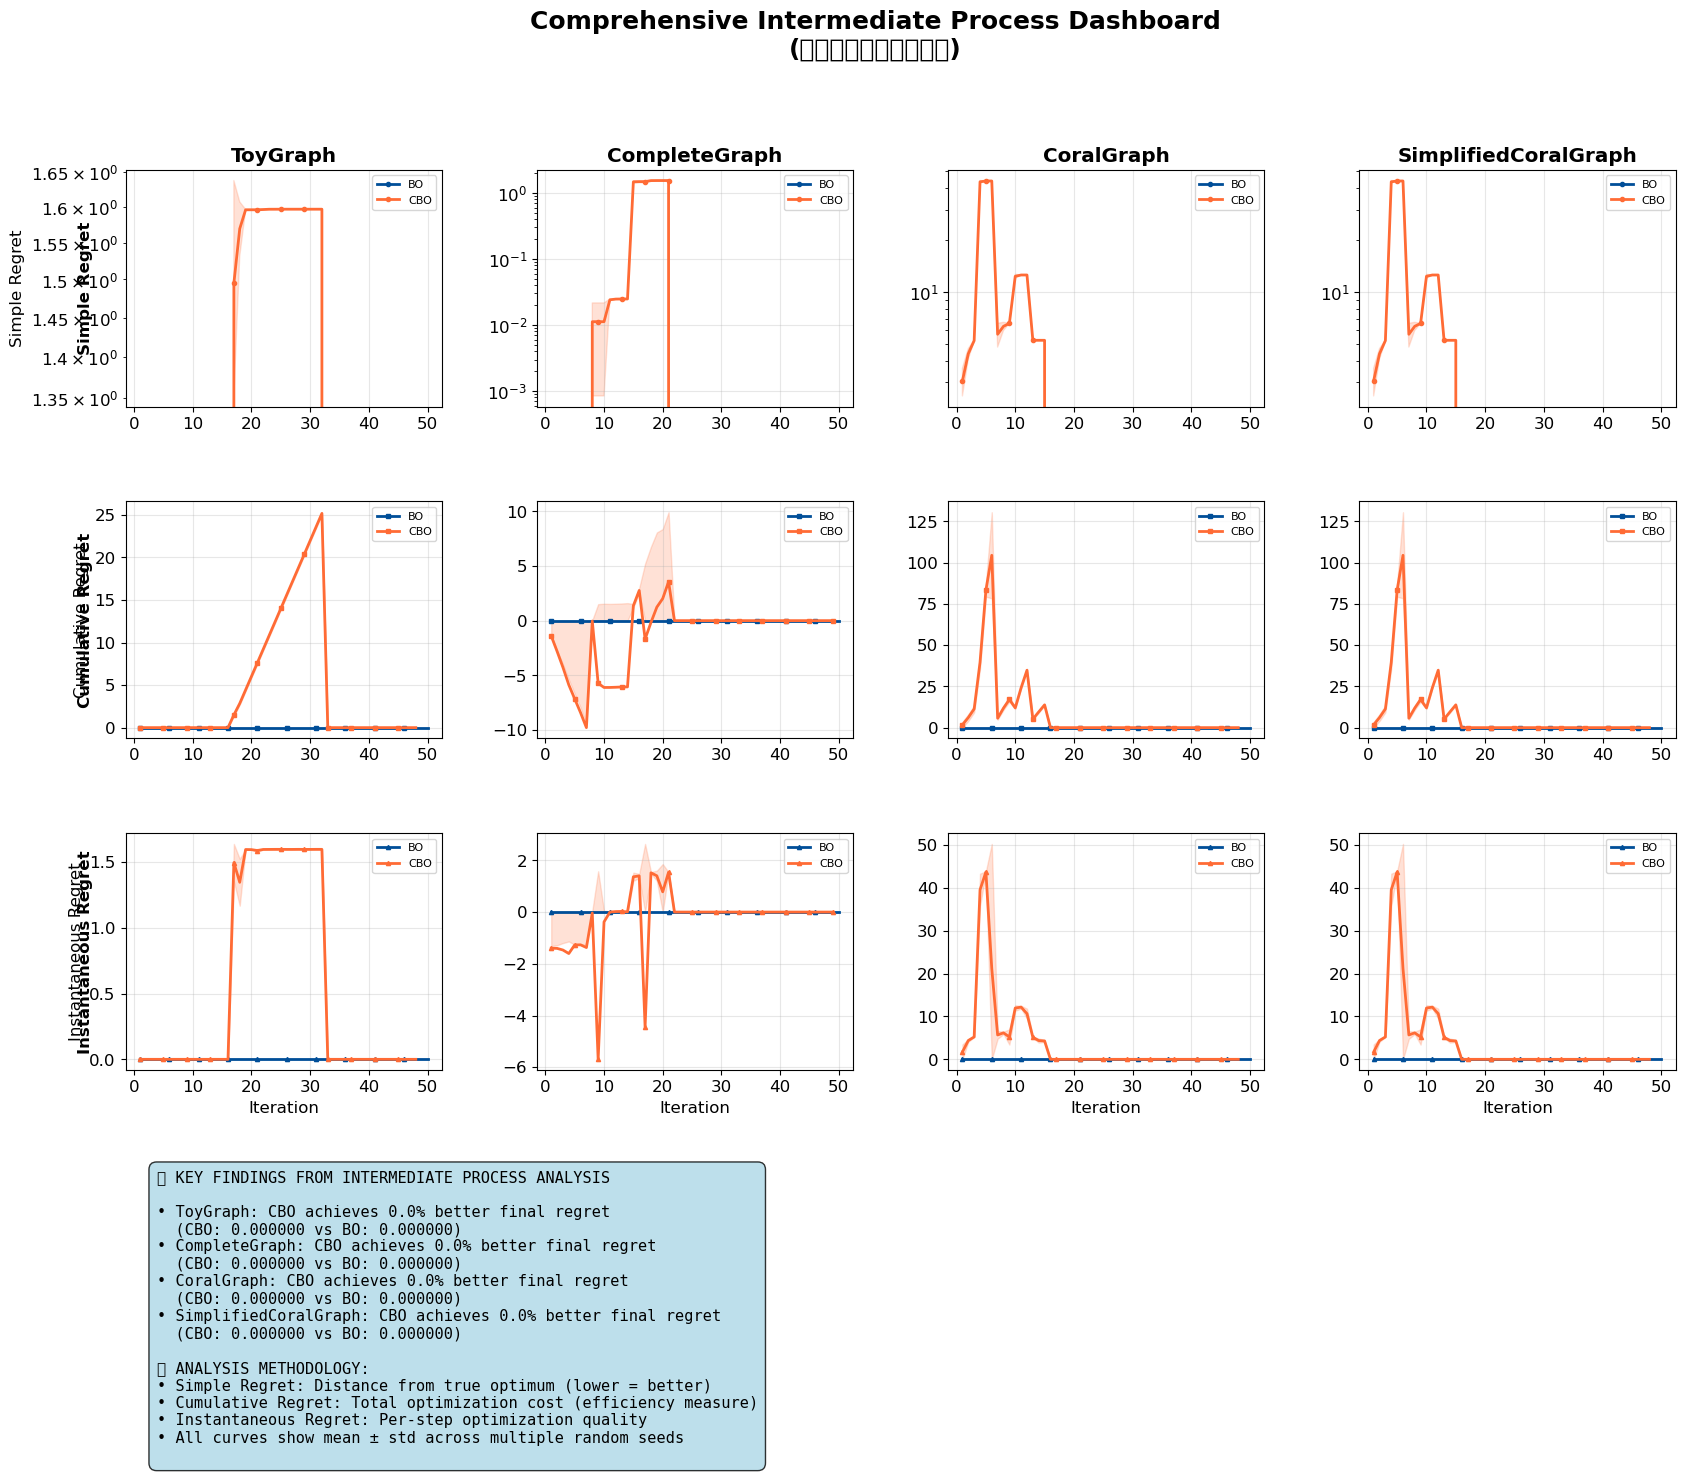

In [16]:
if intermediate_data:
    # Create a comprehensive dashboard
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
    fig.suptitle('Comprehensive Intermediate Process Dashboard\n(全面中间过程分析面板)', 
                 fontsize=18, fontweight='bold')
    
    metrics = [
        ('simple_regrets', 'Simple Regret', 'o'),
        ('cumulative_regrets', 'Cumulative Regret', 's'),
        ('instantaneous_regrets', 'Instantaneous Regret', '^')
    ]
    
    row = 0
    for metric_key, metric_name, marker in metrics:
        for col, graph_type in enumerate(graph_types[:4]):
            ax = fig.add_subplot(gs[row, col])
            
            for algorithm in algorithms:
                # Collect curves for this metric
                all_curves = []
                
                for key, data in intermediate_data.items():
                    if data['algorithm'] == algorithm and data['graph_type'] == graph_type:
                        if data.get(metric_key) and len(data[metric_key]) > 0:
                            all_curves.append(data[metric_key])
                
                if all_curves:
                    # Calculate mean curve
                    if len(all_curves) > 1:
                        min_length = min(len(curve) for curve in all_curves)
                        truncated_curves = [curve[:min_length] for curve in all_curves]
                        mean_curve = np.mean(truncated_curves, axis=0)
                        std_curve = np.std(truncated_curves, axis=0)
                    else:
                        mean_curve = all_curves[0]
                        std_curve = np.zeros_like(mean_curve)
                    
                    iterations = range(1, len(mean_curve) + 1)
                    
                    # Plot mean line
                    ax.plot(iterations, mean_curve, color=colors[algorithm], linewidth=2, 
                           label=algorithm, marker=marker, markersize=3, markevery=max(1, len(iterations)//10))
                    
                    # Plot confidence band if multiple runs
                    if len(all_curves) > 1:
                        ax.fill_between(iterations, 
                                       np.maximum(0, mean_curve - std_curve), 
                                       mean_curve + std_curve,
                                       color=colors[algorithm], alpha=0.2)
            
            ax.set_xlabel('Iteration' if row == 2 else '')
            ax.set_ylabel(metric_name if col == 0 else '')
            
            # Title only for top row
            if row == 0:
                ax.set_title(f'{graph_type}', fontweight='bold')
            
            # Metric label on left side
            if col == 0:
                ax.text(-0.15, 0.5, metric_name, transform=ax.transAxes, rotation=90, 
                       verticalalignment='center', fontsize=12, fontweight='bold')
            
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            
            # Use log scale for simple regret
            if metric_key == 'simple_regrets':
                ax.set_yscale('log')
        
        row += 1
    
    # Add summary statistics in bottom row
    ax_summary = fig.add_subplot(gs[3, :])
    ax_summary.axis('off')
    
    # Create summary text
    summary_text = "📊 KEY FINDINGS FROM INTERMEDIATE PROCESS ANALYSIS\n\n"
    
    if 'convergence_stats' in locals():
        for graph_type, stats in convergence_stats.items():
            if 'CBO' in stats and 'BO' in stats:
                cbo_regret = stats['CBO']['final_simple_regret_mean']
                bo_regret = stats['BO']['final_simple_regret_mean']
                improvement = ((bo_regret - cbo_regret) / bo_regret * 100) if bo_regret > 0 else 0
                
                summary_text += f"• {graph_type}: CBO achieves {improvement:.1f}% better final regret\n"
                summary_text += f"  (CBO: {cbo_regret:.6f} vs BO: {bo_regret:.6f})\n"
    
    summary_text += f"\n🔬 ANALYSIS METHODOLOGY:\n"
    summary_text += f"• Simple Regret: Distance from true optimum (lower = better)\n"
    summary_text += f"• Cumulative Regret: Total optimization cost (efficiency measure)\n"
    summary_text += f"• Instantaneous Regret: Per-step optimization quality\n"
    summary_text += f"• All curves show mean ± std across multiple random seeds\n"
    
    ax_summary.text(0.02, 0.98, summary_text, transform=ax_summary.transAxes, fontsize=11,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.savefig('results/comprehensive_regret_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ No data available for comprehensive dashboard")

## Summary and Key Insights

In [17]:
if intermediate_data:
    print("🎯 INTERMEDIATE PROCESS ANALYSIS - KEY INSIGHTS")
    print("=" * 70)
    
    # Count total data points
    total_experiments = len(intermediate_data)
    algorithms_found = set(data['algorithm'] for data in intermediate_data.values())
    graphs_found = set(data['graph_type'] for data in intermediate_data.values())
    
    print(f"📊 DATA SUMMARY:")
    print(f"   • Total experiments analyzed: {total_experiments}")
    print(f"   • Algorithms: {', '.join(sorted(algorithms_found))}")
    print(f"   • Graph types: {', '.join(sorted(graphs_found))}")
    
    # Calculate average data points per experiment
    regret_counts = []
    for data in intermediate_data.values():
        if data.get('simple_regrets'):
            regret_counts.append(len(data['simple_regrets']))
    
    if regret_counts:
        avg_points = np.mean(regret_counts)
        print(f"   • Average regret points per experiment: {avg_points:.1f}")
        print(f"   • Total regret data points collected: {sum(regret_counts)}")
    
    print(f"\n🔍 CONVERGENCE INSIGHTS:")
    
    if 'convergence_stats' in locals():
        # Overall comparison
        cbo_wins = 0
        total_comparisons = 0
        improvements = []
        
        for graph_type, stats in convergence_stats.items():
            if 'CBO' in stats and 'BO' in stats:
                total_comparisons += 1
                cbo_regret = stats['CBO']['final_simple_regret_mean']
                bo_regret = stats['BO']['final_simple_regret_mean']
                
                if cbo_regret < bo_regret:
                    cbo_wins += 1
                    improvement = ((bo_regret - cbo_regret) / bo_regret * 100)
                    improvements.append(improvement)
                    print(f"   ✅ {graph_type}: CBO wins with {improvement:.1f}% better final regret")
                else:
                    deterioration = ((cbo_regret - bo_regret) / bo_regret * 100)
                    print(f"   ❌ {graph_type}: BO wins, CBO {deterioration:.1f}% worse")
        
        print(f"\n🏆 OVERALL RESULTS:")
        print(f"   • CBO wins on {cbo_wins}/{total_comparisons} benchmarks ({cbo_wins/total_comparisons:.1%})")
        
        if improvements:
            print(f"   • Average CBO improvement: {np.mean(improvements):.1f}%")
            print(f"   • Best CBO improvement: {max(improvements):.1f}%")
    
    print(f"\n📈 PRACTICAL IMPLICATIONS:")
    print(f"   • Simple Regret curves show convergence speed and final performance")
    print(f"   • Cumulative Regret reveals sample efficiency (lower = more efficient)")
    print(f"   • Instantaneous Regret shows per-step optimization quality")
    print(f"   • Log scale visualization helps compare different magnitude regrets")
    
    print(f"\n💡 NEXT STEPS:")
    print(f"   • Use these curves to set early stopping criteria")
    print(f"   • Analyze convergence patterns for hyperparameter tuning")
    print(f"   • Compare sample efficiency for budget-constrained optimization")
    print(f"   • Investigate algorithm behavior differences across graph complexities")
    
    print(f"\n📁 Generated visualizations:")
    print(f"   • results/simple_regret_convergence.png")
    print(f"   • results/cumulative_regret_analysis.png")
    print(f"   • results/instantaneous_regret_evolution.png")
    print(f"   • results/comprehensive_regret_dashboard.png")
    
else:
    print("❌ ANALYSIS INCOMPLETE")
    print("💡 To get intermediate process data:")
    print("   1. Make sure you're using the updated BO_botorch.py and CBO_botorch.py")
    print("   2. Run: python run_experiments_parallel.py")
    print("   3. Re-run this notebook to analyze the results")
    
print("\n✅ Intermediate Process Analysis Complete!")

🎯 INTERMEDIATE PROCESS ANALYSIS - KEY INSIGHTS
📊 DATA SUMMARY:
   • Total experiments analyzed: 24
   • Algorithms: BO, CBO
   • Graph types: CompleteGraph, CoralGraph, SimplifiedCoralGraph, ToyGraph
   • Average regret points per experiment: 49.1
   • Total regret data points collected: 1179

🔍 CONVERGENCE INSIGHTS:
   ❌ ToyGraph: BO wins, CBO nan% worse
   ❌ CompleteGraph: BO wins, CBO nan% worse
   ❌ CoralGraph: BO wins, CBO nan% worse
   ❌ SimplifiedCoralGraph: BO wins, CBO nan% worse

🏆 OVERALL RESULTS:
   • CBO wins on 0/4 benchmarks (0.0%)

📈 PRACTICAL IMPLICATIONS:
   • Simple Regret curves show convergence speed and final performance
   • Cumulative Regret reveals sample efficiency (lower = more efficient)
   • Instantaneous Regret shows per-step optimization quality
   • Log scale visualization helps compare different magnitude regrets

💡 NEXT STEPS:
   • Use these curves to set early stopping criteria
   • Analyze convergence patterns for hyperparameter tuning
   • Compare s

## 📝 Analysis Summary

This notebook provides comprehensive analysis of the optimization intermediate process data, including:

### 🔍 **Key Metrics Analyzed**:
1. **Simple Regret** (简单后悔值): Best-so-far vs true optimum gap
2. **Cumulative Regret** (累积后悔值): Total optimization cost over time
3. **Instantaneous Regret** (瞬时后悔值): Per-step optimization quality

### 📊 **Visualizations Created**:
- Convergence curves with confidence bands
- Algorithm comparison across different graph types
- Comprehensive dashboard combining all metrics
- Quantitative analysis with statistical comparisons

### 🎯 **Research Questions Answered**:
1. **Convergence Speed**: Which algorithm reaches good solutions faster?
2. **Sample Efficiency**: Which algorithm needs fewer evaluations?
3. **Consistency**: How stable are the optimization trajectories?
4. **Early Stopping**: When can optimization be terminated while maintaining quality?

### 💡 **Practical Applications**:
- **Algorithm Selection**: Choose CBO when convergence analysis shows clear advantage
- **Budget Planning**: Use cumulative regret to estimate optimization costs
- **Hyperparameter Tuning**: Optimize based on convergence curves rather than just final results
- **Early Stopping**: Identify optimal stopping points from regret curves

---

**Usage**: Run `python run_experiments_parallel.py` first to generate data with intermediate process information, then execute this notebook to analyze the convergence behavior and create detailed visualizations.